## Import libaries

In [114]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import statistics
from numpy import array

import gc
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader
# ignore warnings
import warnings
import torch.optim as optim

warnings.filterwarnings("ignore")

## Fetch Data

In [115]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)

True
True
cuda


In [116]:
# read data
filePath = '/kaggle/input/beijing-multisite-airquality-data-set'
allFiles = glob.glob(filePath + "/*.csv")
dataFrames = []
for i in allFiles:
    df = pd.read_csv(i, index_col=None, header=0)
    dataFrames.append(df)
data = pd.concat(dataFrames)
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,16.0,51.0,3.0,29.0,400.0,73.0,12.5,1013.5,-16.2,0.0,NW,2.4,Dongsi
35060,35061,2017,2,28,20,18.0,45.0,3.0,43.0,500.0,54.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Dongsi
35061,35062,2017,2,28,21,23.0,58.0,5.0,61.0,700.0,28.0,10.8,1014.2,-13.3,0.0,NW,1.1,Dongsi
35062,35063,2017,2,28,22,23.0,53.0,9.0,75.0,900.0,15.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Dongsi


In [117]:
# drop the row no column and rename the columns
data.drop(["No"], axis=1, inplace=True)
data.rename(columns = {'year': 'Year',
                       'month': 'Month',
                       'day': "Day",
                       'hour': 'Hour',
                       'pm2.5': 'PM2.5',
                       'DEWP': 'DewP',
                       'TEMP': 'Temp',
                       'PRES': 'Press',
                       'RAIN': 'Rain',
                       'wd': 'WinDir',
                       'WSPM': 'WinSpeed',
                       'station': 'Station'}, inplace = True)
data

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station
0,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,16.0,51.0,3.0,29.0,400.0,73.0,12.5,1013.5,-16.2,0.0,NW,2.4,Dongsi
35060,2017,2,28,20,18.0,45.0,3.0,43.0,500.0,54.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Dongsi
35061,2017,2,28,21,23.0,58.0,5.0,61.0,700.0,28.0,10.8,1014.2,-13.3,0.0,NW,1.1,Dongsi
35062,2017,2,28,22,23.0,53.0,9.0,75.0,900.0,15.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Dongsi


## 1-3-1 Missing value

In [118]:
data[20:40]

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station
20,2013,3,1,20,12.0,14.0,14.0,41.0,500.0,52.0,1.7,1029.1,-17.3,0.0,N,2.1,Guanyuan
21,2013,3,1,21,11.0,14.0,24.0,51.0,500.0,42.0,0.6,1030.1,-16.7,0.0,ENE,0.8,Guanyuan
22,2013,3,1,22,10.0,15.0,11.0,60.0,600.0,31.0,0.9,1030.5,-17.4,0.0,ENE,1.8,Guanyuan
23,2013,3,1,23,13.0,15.0,11.0,51.0,600.0,37.0,-0.2,1030.5,-17.4,0.0,ENE,1.4,Guanyuan
24,2013,3,2,0,6.0,15.0,16.0,44.0,500.0,46.0,-0.4,1031.0,-17.6,0.0,ENE,1.4,Guanyuan
25,2013,3,2,1,3.0,8.0,14.0,33.0,400.0,57.0,-1.0,1031.3,-17.3,0.0,NNE,1.1,Guanyuan
26,2013,3,2,2,4.0,6.0,NaN,26.0,400.0,62.0,-1.5,1030.9,-16.9,0.0,E,1.7,Guanyuan
27,2013,3,2,3,3.0,6.0,12.0,32.0,NaN,79.0,-1.4,1030.6,-17.6,0.0,NNE,1.4,Guanyuan
28,2013,3,2,4,3.0,6.0,9.0,NaN,400.0,51.0,-1.5,1030.8,-17.7,0.0,NNW,0.9,Guanyuan
29,2013,3,2,5,3.0,6.0,15.0,59.0,500.0,32.0,-1.8,1030.1,-17.5,0.0,NNE,2.0,Guanyuan


In [119]:
# check the null data
data.isnull().sum()

Year            0
Month           0
Day             0
Hour            0
PM2.5        8739
PM10         6449
SO2          9021
NO2         12116
CO          20701
O3          13277
Temp          398
Press         393
DewP          403
Rain          390
WinDir       1822
WinSpeed      318
Station         0
dtype: int64

In [120]:
data = data.interpolate(method = 'linear')
data[20:40]

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station
20,2013,3,1,20,12.0,14.0,14.0,41.0,500.0,52.0,1.7,1029.1,-17.3,0.0,N,2.1,Guanyuan
21,2013,3,1,21,11.0,14.0,24.0,51.0,500.0,42.0,0.6,1030.1,-16.7,0.0,ENE,0.8,Guanyuan
22,2013,3,1,22,10.0,15.0,11.0,60.0,600.0,31.0,0.9,1030.5,-17.4,0.0,ENE,1.8,Guanyuan
23,2013,3,1,23,13.0,15.0,11.0,51.0,600.0,37.0,-0.2,1030.5,-17.4,0.0,ENE,1.4,Guanyuan
24,2013,3,2,0,6.0,15.0,16.0,44.0,500.0,46.0,-0.4,1031.0,-17.6,0.0,ENE,1.4,Guanyuan
25,2013,3,2,1,3.0,8.0,14.0,33.0,400.0,57.0,-1.0,1031.3,-17.3,0.0,NNE,1.1,Guanyuan
26,2013,3,2,2,4.0,6.0,13.0,26.0,400.0,62.0,-1.5,1030.9,-16.9,0.0,E,1.7,Guanyuan
27,2013,3,2,3,3.0,6.0,12.0,32.0,400.0,79.0,-1.4,1030.6,-17.6,0.0,NNE,1.4,Guanyuan
28,2013,3,2,4,3.0,6.0,9.0,45.5,400.0,51.0,-1.5,1030.8,-17.7,0.0,NNW,0.9,Guanyuan
29,2013,3,2,5,3.0,6.0,15.0,59.0,500.0,32.0,-1.8,1030.1,-17.5,0.0,NNE,2.0,Guanyuan


In [121]:
data.isnull().sum()

Year           0
Month          0
Day            0
Hour           0
PM2.5          0
PM10           0
SO2            0
NO2            0
CO             0
O3             0
Temp           0
Press          0
DewP           0
Rain           0
WinDir      1822
WinSpeed       0
Station        0
dtype: int64

In [122]:
# fill the null values in categorical columns with mode specific to certain column

# fill in the missing data in the WinDir column with mode values according to the Station.
unique_Station = pd.unique(data.Station)

# find columns mode value in WinDir column according to Station column specific
# Equalize the mode values of columns to the missing values
temp_data = data.copy()  # set temp_data variable to avoid losing real data
columns = ["WinDir"] # it can be add more column
for c in unique_Station:
    
    # create Station filter
    Station_filtre = temp_data.Station == c
    
    # filter data by Station
    filtered_data = temp_data[Station_filtre]
    
    # find mode for WinDir specific to Station
    for column in columns:
        mode = statistics.mode(filtered_data[column])
        filtered_data[column] = filtered_data[column].fillna(mode)
        print(f"Missing Value in {column} column fill with {mode} when Station:{c}")

    # Synchronize data filled with missing values in WinDir to data temporary            
    temp_data[Station_filtre] = filtered_data

# equate the deprecated temporary data to the real data variable
data = temp_data.copy() 

Missing Value in WinDir column fill with NE when Station:Guanyuan
Missing Value in WinDir column fill with NE when Station:Aotizhongxin
Missing Value in WinDir column fill with NE when Station:Wanliu
Missing Value in WinDir column fill with ENE when Station:Tiantan
Missing Value in WinDir column fill with NE when Station:Wanshouxigong
Missing Value in WinDir column fill with ENE when Station:Nongzhanguan
Missing Value in WinDir column fill with NNE when Station:Shunyi
Missing Value in WinDir column fill with NNW when Station:Changping
Missing Value in WinDir column fill with NNW when Station:Dingling
Missing Value in WinDir column fill with NW when Station:Huairou
Missing Value in WinDir column fill with N when Station:Gucheng
Missing Value in WinDir column fill with ENE when Station:Dongsi


## 1-3-2 Encoding Categorical Variable

In [123]:
data['WinDir'][:5]

0    NNW
1      N
2    NNW
3     NW
4      N
Name: WinDir, dtype: object

In [124]:
data['WinDir'][0]

0    NNW
0    NNW
0    NNW
0    NNW
0    WNW
0    NNW
0     NW
0      E
0      E
0    WNW
0     NW
0    NNW
Name: WinDir, dtype: object

In [125]:
data = data.replace({'WinDir':{"N":0,"NNE":1*22.5,"NE":2*22.5,"ENE":3*22.5
                               ,"E":4*22.5,"ESE":5*22.5, "SE":6*22.5, "SSE":7*22.5
                               ,"S":8*22.5,"SSW":9*22.5,"SW":10*22.5,"WSW":11*22.5
                               ,"W":12*22.5,"WNW":13*22.5,"NW":14*22.5,"NNW":15*22.5}})

In [126]:
data['WinDir']

0        337.5
1          0.0
2        337.5
3        315.0
4          0.0
         ...  
35059    315.0
35060    292.5
35061    315.0
35062    337.5
35063     22.5
Name: WinDir, Length: 420768, dtype: float64

In [127]:
# creating date field for further analysis by extracting day of the week, month etc.
data['Date']=pd.to_datetime(data[['Year', 'Month', 'Day']])
data.tail()

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station,Date
35059,2017,2,28,19,16.0,51.0,3.0,29.0,400.0,73.0,12.5,1013.5,-16.2,0.0,315.0,2.4,Dongsi,2017-02-28
35060,2017,2,28,20,18.0,45.0,3.0,43.0,500.0,54.0,11.6,1013.6,-15.1,0.0,292.5,0.9,Dongsi,2017-02-28
35061,2017,2,28,21,23.0,58.0,5.0,61.0,700.0,28.0,10.8,1014.2,-13.3,0.0,315.0,1.1,Dongsi,2017-02-28
35062,2017,2,28,22,23.0,53.0,9.0,75.0,900.0,15.0,10.5,1014.4,-12.9,0.0,337.5,1.2,Dongsi,2017-02-28
35063,2017,2,28,23,30.0,71.0,11.0,87.0,1200.0,4.0,8.6,1014.1,-15.9,0.0,22.5,1.3,Dongsi,2017-02-28


In [128]:
# function to find day of the week based on the date field
import calendar
def findDay(date): 
    dayname = calendar.day_name[date.weekday()]
    return dayname

In [129]:
data['DayNames'] = data['Date'].apply(lambda x: findDay(x))
data.head()

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station,Date,DayNames
0,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,337.5,4.4,Guanyuan,2013-03-01,Friday
1,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,0.0,4.7,Guanyuan,2013-03-01,Friday
2,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,337.5,5.6,Guanyuan,2013-03-01,Friday
3,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,315.0,3.1,Guanyuan,2013-03-01,Friday
4,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,0.0,2.0,Guanyuan,2013-03-01,Friday


## Explotary Data Analysis and Data Visualization

In [130]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Year      420768 non-null  int64         
 1   Month     420768 non-null  int64         
 2   Day       420768 non-null  int64         
 3   Hour      420768 non-null  int64         
 4   PM2.5     420768 non-null  float64       
 5   PM10      420768 non-null  float64       
 6   SO2       420768 non-null  float64       
 7   NO2       420768 non-null  float64       
 8   CO        420768 non-null  float64       
 9   O3        420768 non-null  float64       
 10  Temp      420768 non-null  float64       
 11  Press     420768 non-null  float64       
 12  DewP      420768 non-null  float64       
 13  Rain      420768 non-null  float64       
 14  WinDir    420768 non-null  float64       
 15  WinSpeed  420768 non-null  float64       
 16  Station   420768 non-null  object      

In [131]:
# statistical information about data
data.drop(["Year", "Month", "Day", "Hour", "DayNames", "Date"], axis=1).describe()

,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,79.839718,104.910268,15.913090,50.599602,1235.682649,57.237872,13.531692,1010.753337,2.482421,0.064428,157.335889,1.730034
std,80.950217,92.431422,21.896609,35.171277,1161.790893,57.135195,11.437867,10.474302,13.797675,0.820638,108.796324,1.246674
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,10.000000,3.100000,1002.300000,-8.900000,0.000000,67.500000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,44.000000,14.500000,1010.400000,3.000000,0.000000,135.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,247.500000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,337.500000,13.200000


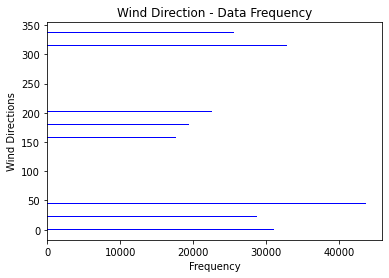

Number of Wind Direction 
45.0     43699
67.5     34376
315.0    32902
0.0      31028
90.0     29752
225.0    28756
22.5     28715
337.5    25606
292.5    24375
112.5    24220
202.5    22563
135.0    20074
247.5    20040
180.0    19405
157.5    17694
270.0    17563
Name: WinDir, dtype: int64


In [132]:
# Number of sample according to WinDir
plt.figure()
plt.barh(data["WinDir"].value_counts().index, data["WinDir"].value_counts(), color = "b")
#plt.xticks(data["WinDir"].values)
plt.xlabel("Frequency")
plt.ylabel("Wind Directions")
plt.title("Wind Direction - Data Frequency")
plt.show()
print(f"Number of Wind Direction \n{data['WinDir'].value_counts()}")

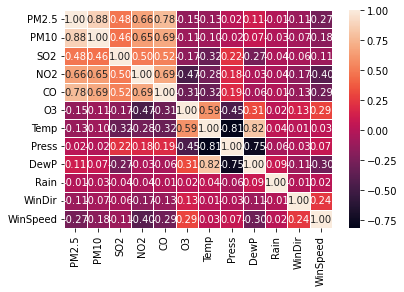

In [133]:
sns.heatmap(data.drop(["Year", "Month", "Day", "Hour", "Date"], axis=1).corr(),
            annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### Weekly Analysis

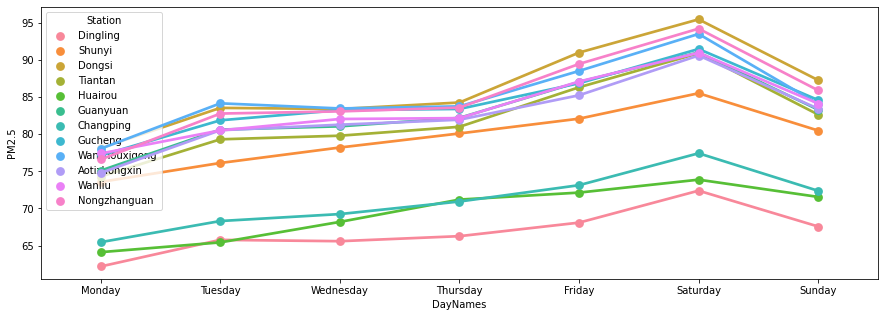

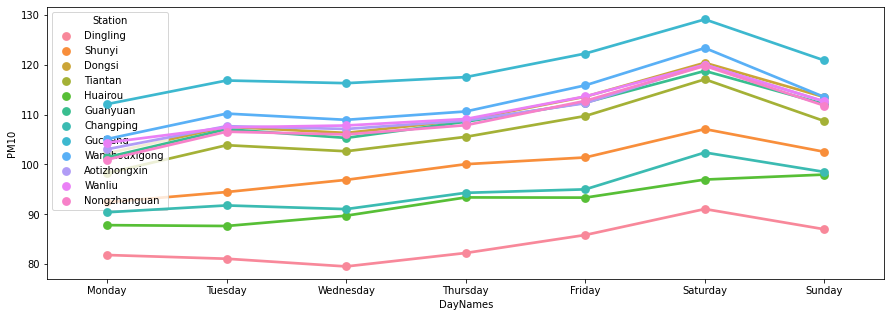

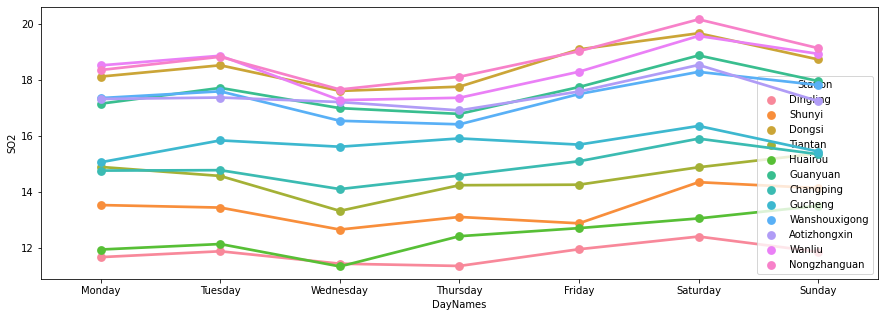

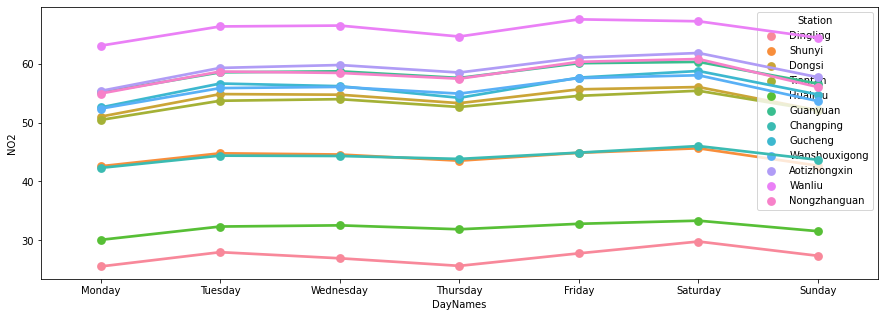

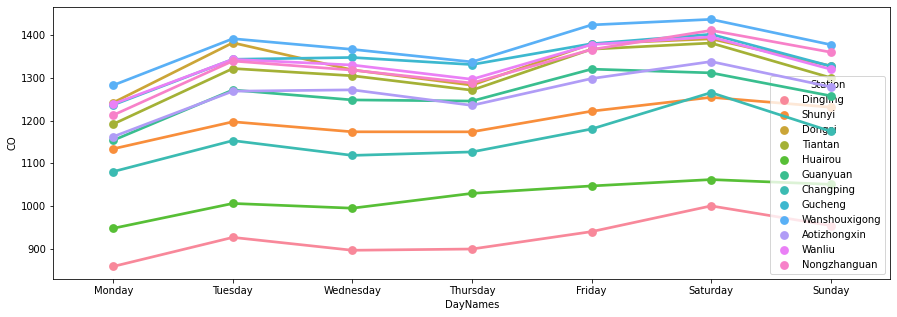

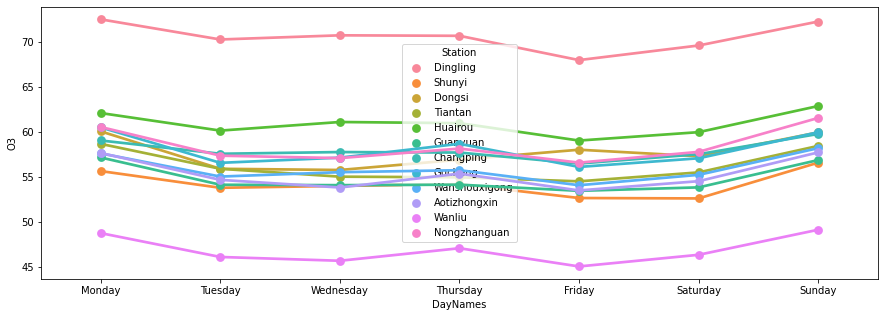

In [134]:
compounds = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]

custom_day = {'Monday':0, 'Tuesday':1, 'Wednesday':2,
              'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
for i in compounds:
    df = data[[i, 'DayNames',
               'Station']].groupby(["Station",
                                    "DayNames"]).mean().reset_index().sort_values(by=['Station',
                                                                                      'DayNames'], ascending=True)
    df = df.iloc[df['DayNames'].map(custom_day).argsort()]
    f,ax=plt.subplots(figsize=(15,5))
    sns.pointplot(x='DayNames', y=i, data=df, hue="Station")

### Hourly Analysis

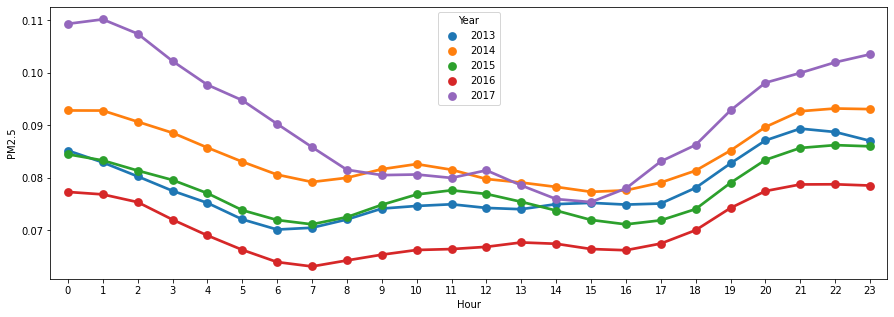

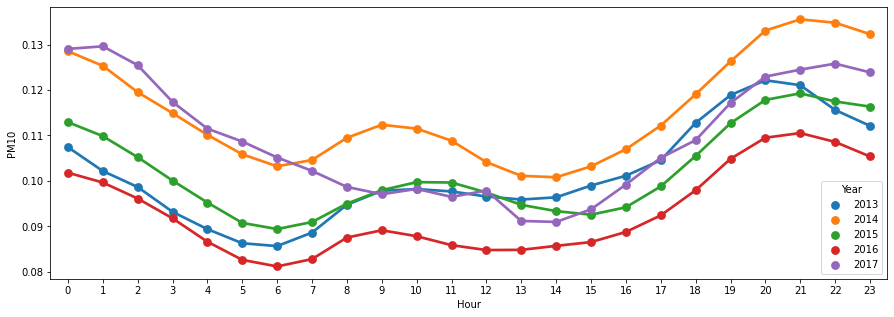

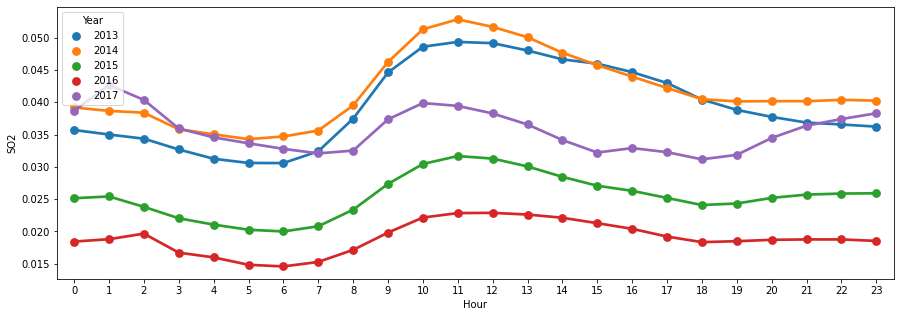

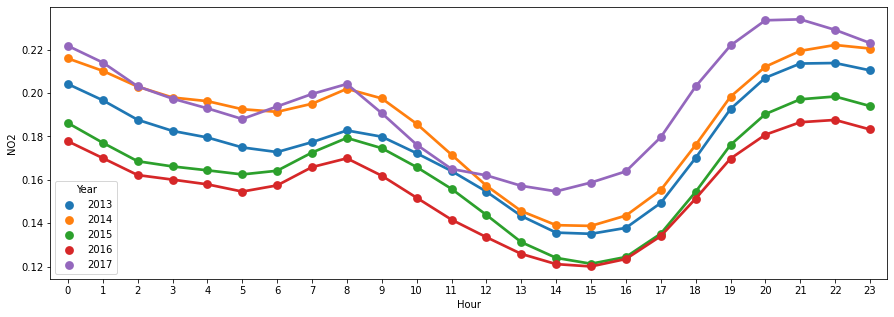

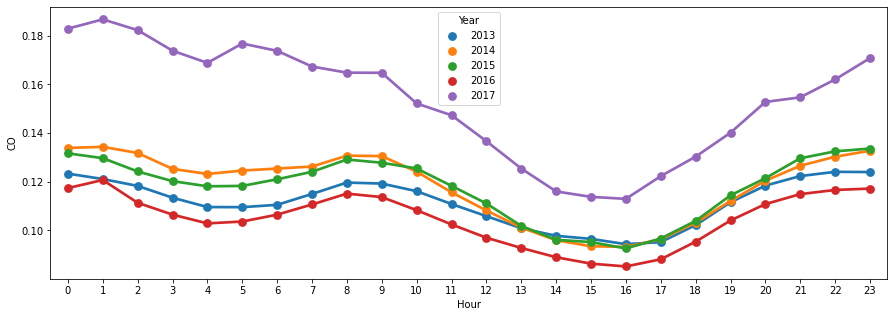

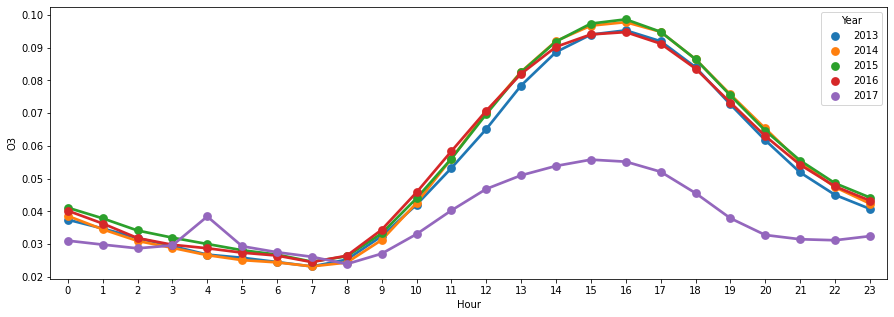

In [191]:
for i in compounds:   
    df = data[[i, 'Hour', 'Year']].groupby(["Year",
                                                 "Hour"]).mean().reset_index().sort_values(by=['Year',
                                                                                                 'Hour'], ascending=False)
    f,ax=plt.subplots(figsize=(15,5))
    sns.pointplot(x='Hour', y=i, data=df, hue="Year")
    if i == 'PM2.5':
        plt.savefig('hourly-analysis'+ i +'.png')
    plt.show()


### Station Based Analysis

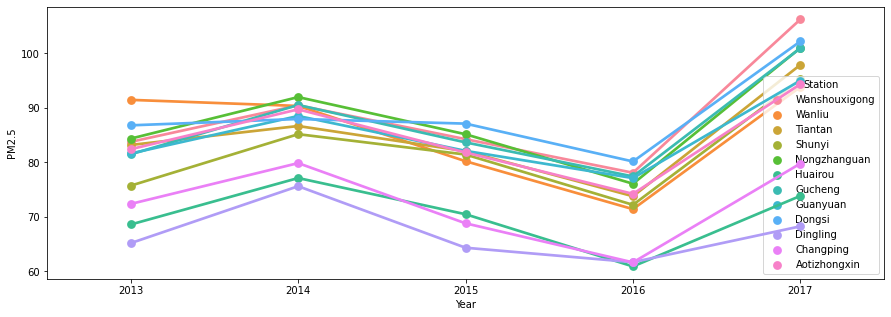

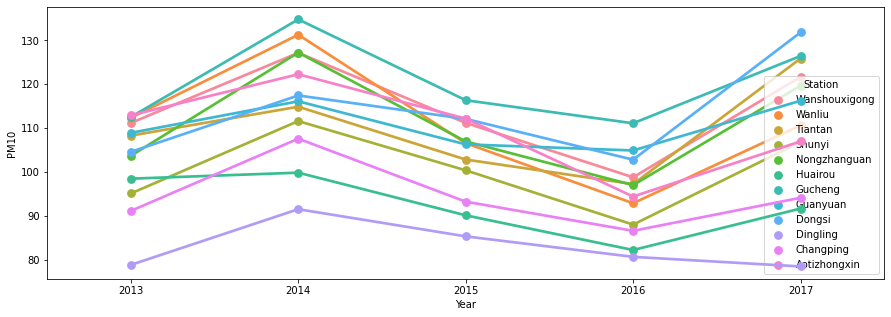

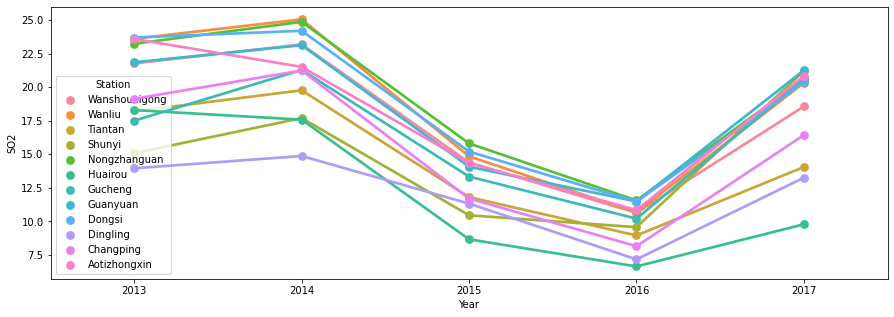

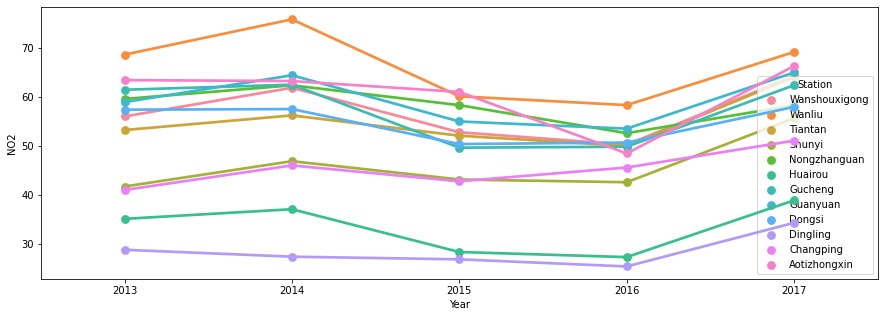

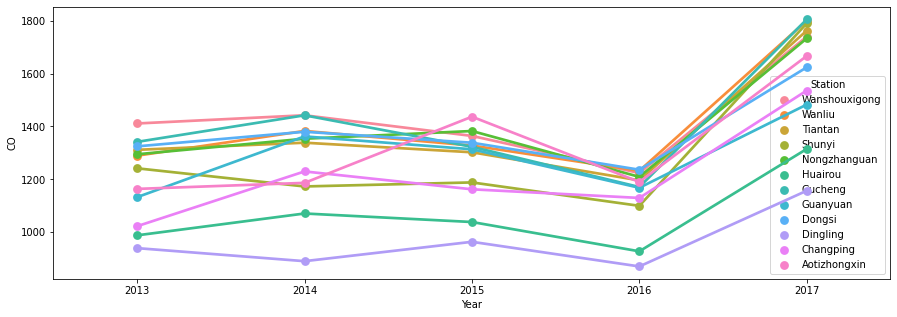

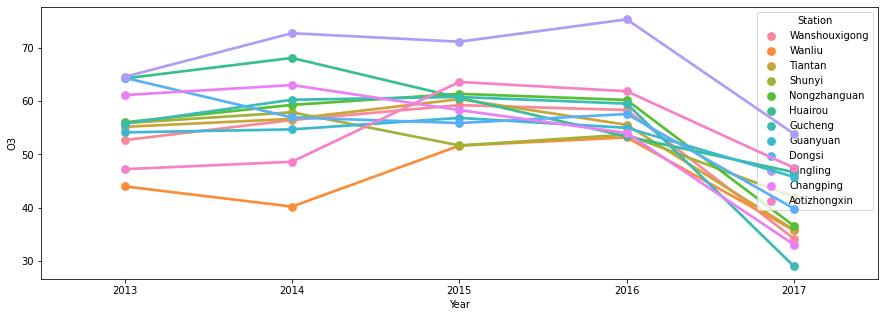

In [136]:
for i in compounds:  
    df = data[[i, 'Year', 'Station']].groupby(["Year",
                                               "Station"]).mean().reset_index().sort_values(by=['Station',
                                                                                                'Year'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df, hue="Station")
    plt.show()

## 1-3-3 Normalization

In [137]:
# save min and max for de-normalize PM2.5
max_pm = data['PM2.5'].max()
min_pm = data['PM2.5'].min()

In [138]:
cols = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "Temp", "Press", "DewP","WinDir", "WinSpeed"]

for co in cols:
    data[co] = (data[co] - data[co].min()) / (data[co].max() - data[co].min())  
data

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station,Date,DayNames
0,2013,3,1,0,0.002006,0.002006,0.027444,0.065658,0.020202,0.064239,0.312195,0.672185,0.339310,0.0,1.000000,0.333333,Guanyuan,2013-03-01,Friday
1,2013,3,1,1,0.002006,0.002006,0.025443,0.055277,0.020202,0.067040,0.305691,0.675497,0.347586,0.0,0.000000,0.356061,Guanyuan,2013-03-01,Friday
2,2013,3,1,2,0.001003,0.001003,0.019440,0.062198,0.020202,0.064239,0.305691,0.680464,0.347586,0.0,1.000000,0.424242,Guanyuan,2013-03-01,Friday
3,2013,3,1,3,0.001003,0.004012,0.013436,0.079500,0.030303,0.057701,0.300813,0.697020,0.331034,0.0,0.933333,0.234848,Guanyuan,2013-03-01,Friday
4,2013,3,1,4,0.001003,0.004012,0.009434,0.044895,0.030303,0.066106,0.291057,0.708609,0.329655,0.0,0.000000,0.151515,Guanyuan,2013-03-01,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,0.014042,0.049147,0.005432,0.096803,0.030303,0.067974,0.526829,0.514901,0.375172,0.0,0.933333,0.181818,Dongsi,2017-02-28,Tuesday
35060,2017,2,28,20,0.016048,0.043129,0.005432,0.145250,0.040404,0.050230,0.512195,0.516556,0.390345,0.0,0.866667,0.068182,Dongsi,2017-02-28,Tuesday
35061,2017,2,28,21,0.021063,0.056169,0.009434,0.207540,0.060606,0.025949,0.499187,0.526490,0.415172,0.0,0.933333,0.083333,Dongsi,2017-02-28,Tuesday
35062,2017,2,28,22,0.021063,0.051153,0.017439,0.255987,0.080808,0.013808,0.494309,0.529801,0.420690,0.0,1.000000,0.090909,Dongsi,2017-02-28,Tuesday


## 1-3-4 Pearson Correlation

In [139]:
local_df = data.copy(deep=True)

station_name = local_df.Station.unique()
station_name

array(['Guanyuan', 'Aotizhongxin', 'Wanliu', 'Tiantan', 'Wanshouxigong',
       'Nongzhanguan', 'Shunyi', 'Changping', 'Dingling', 'Huairou',
       'Gucheng', 'Dongsi'], dtype=object)

In [140]:
new_df = pd.DataFrame()
for name_s in station_name:
    #print(name_s)
    df1 = local_df[local_df['Station'] == name_s]
    #print(df1)
    new_df['PM2.5_'+name_s] = df1['PM2.5']
new_df

,PM2.5_Guanyuan,PM2.5_Aotizhongxin,PM2.5_Wanliu,PM2.5_Tiantan,PM2.5_Wanshouxigong,PM2.5_Nongzhanguan,PM2.5_Shunyi,PM2.5_Changping,PM2.5_Dingling,PM2.5_Huairou,PM2.5_Gucheng,PM2.5_Dongsi
0,0.002006,0.002006,0.006018,0.004012,0.007021,0.003009,0.001003,0.001003,0.002006,0.005015,0.004012,0.007021
1,0.002006,0.006018,0.007021,0.004012,0.009027,0.006018,0.010030,0.001003,0.005015,0.002006,0.004012,0.002006
2,0.001003,0.005015,0.001003,0.004012,0.006018,0.001003,0.012036,0.001003,0.003009,0.002006,0.003009,0.005015
3,0.001003,0.004012,0.009027,0.004012,0.006018,0.003009,0.010030,0.001003,0.004012,0.001003,0.004012,0.001003
4,0.001003,0.001003,0.001003,0.003009,0.006018,0.003009,0.010030,0.001003,0.003009,0.001003,0.003009,0.001003
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.011033,0.010030,0.009027,0.018054,0.009027,0.012036,0.025075,0.026078,0.009027,0.014042,0.012036,0.014042
35060,0.018054,0.011033,0.013039,0.009027,0.011033,0.016048,0.045135,0.010030,0.011033,0.019057,0.025075,0.016048
35061,0.014042,0.014042,0.011033,0.016048,0.012036,0.013039,0.016048,0.005015,0.007021,0.015045,0.020060,0.021063
35062,0.009027,0.019057,0.010030,0.013039,0.010030,0.009027,0.016048,0.009027,0.008024,0.009027,0.007021,0.021063


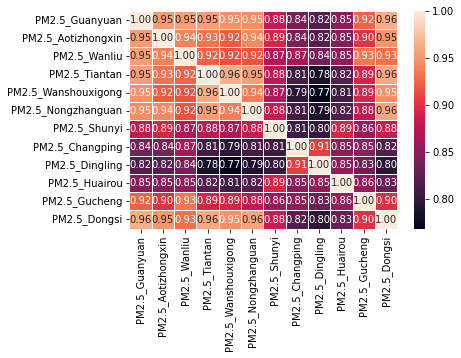

In [141]:
sns.heatmap(new_df.corr(),
            annot=True, linewidths=.5, fmt= '.2f')
plt.savefig('conf_pm2.png')
plt.show()

## 1-3-5 Feature Selection

In [142]:
df3 = local_df[local_df['Station'] == 'Aotizhongxin']
sel_col = ['PM10','CO','Temp','Press','DewP','Rain','WinDir','WinSpeed']
df3 = df3[sel_col]
df3

,PM10,CO,Temp,Press,DewP,Rain,WinDir,WinSpeed
0,0.002006,0.020202,0.312195,0.672185,0.339310,0.0,1.000000,0.333333
1,0.006018,0.020202,0.305691,0.675497,0.347586,0.0,0.000000,0.356061
2,0.005015,0.020202,0.305691,0.680464,0.347586,0.0,1.000000,0.424242
3,0.004012,0.020202,0.300813,0.697020,0.331034,0.0,0.933333,0.234848
4,0.001003,0.020202,0.291057,0.708609,0.329655,0.0,0.000000,0.151515
...,...,...,...,...,...,...,...,...
35059,0.027081,0.030303,0.526829,0.514901,0.375172,0.0,0.933333,0.181818
35060,0.035105,0.040404,0.512195,0.516556,0.390345,0.0,0.866667,0.068182
35061,0.035105,0.060606,0.499187,0.526490,0.415172,0.0,0.933333,0.083333
35062,0.042126,0.060606,0.494309,0.529801,0.420690,0.0,1.000000,0.090909


In [143]:
dfs = pd.concat([new_df,df3], axis=1)
dfs

,PM2.5_Guanyuan,PM2.5_Aotizhongxin,PM2.5_Wanliu,PM2.5_Tiantan,PM2.5_Wanshouxigong,PM2.5_Nongzhanguan,PM2.5_Shunyi,PM2.5_Changping,PM2.5_Dingling,PM2.5_Huairou,PM2.5_Gucheng,PM2.5_Dongsi,PM10,CO,Temp,Press,DewP,Rain,WinDir,WinSpeed
0,0.002006,0.002006,0.006018,0.004012,0.007021,0.003009,0.001003,0.001003,0.002006,0.005015,0.004012,0.007021,0.002006,0.020202,0.312195,0.672185,0.339310,0.0,1.000000,0.333333
1,0.002006,0.006018,0.007021,0.004012,0.009027,0.006018,0.010030,0.001003,0.005015,0.002006,0.004012,0.002006,0.006018,0.020202,0.305691,0.675497,0.347586,0.0,0.000000,0.356061
2,0.001003,0.005015,0.001003,0.004012,0.006018,0.001003,0.012036,0.001003,0.003009,0.002006,0.003009,0.005015,0.005015,0.020202,0.305691,0.680464,0.347586,0.0,1.000000,0.424242
3,0.001003,0.004012,0.009027,0.004012,0.006018,0.003009,0.010030,0.001003,0.004012,0.001003,0.004012,0.001003,0.004012,0.020202,0.300813,0.697020,0.331034,0.0,0.933333,0.234848
4,0.001003,0.001003,0.001003,0.003009,0.006018,0.003009,0.010030,0.001003,0.003009,0.001003,0.003009,0.001003,0.001003,0.020202,0.291057,0.708609,0.329655,0.0,0.000000,0.151515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.011033,0.010030,0.009027,0.018054,0.009027,0.012036,0.025075,0.026078,0.009027,0.014042,0.012036,0.014042,0.027081,0.030303,0.526829,0.514901,0.375172,0.0,0.933333,0.181818
35060,0.018054,0.011033,0.013039,0.009027,0.011033,0.016048,0.045135,0.010030,0.011033,0.019057,0.025075,0.016048,0.035105,0.040404,0.512195,0.516556,0.390345,0.0,0.866667,0.068182
35061,0.014042,0.014042,0.011033,0.016048,0.012036,0.013039,0.016048,0.005015,0.007021,0.015045,0.020060,0.021063,0.035105,0.060606,0.499187,0.526490,0.415172,0.0,0.933333,0.083333
35062,0.009027,0.019057,0.010030,0.013039,0.010030,0.009027,0.016048,0.009027,0.008024,0.009027,0.007021,0.021063,0.042126,0.060606,0.494309,0.529801,0.420690,0.0,1.000000,0.090909


In [144]:
dfs.to_csv('new_data.csv', index = False)

## 1-3-6 Supervised dataset

In [145]:
split_point = 28502
df_train = dfs[:split_point]
df_test = dfs[split_point:]

In [146]:
df_train['PM2.5_Aotizhongxin']

0        0.002006
1        0.006018
2        0.005015
3        0.004012
4        0.001003
           ...   
28497    0.030090
28498    0.033099
28499    0.034102
28500    0.028084
28501    0.030090
Name: PM2.5_Aotizhongxin, Length: 28502, dtype: float64

In [147]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
             break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]['PM2.5_Aotizhongxin']
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [148]:
# Take into consideration last 24 hours, and perform forecasting for next 1 hour
LOOK_BACK = 24
FORECAST_RANGE = 1
X_train1, y_train1 = split_sequence(df_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test1, y_test1 = split_sequence(df_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

(28478, 24, 20)
(28478, 1)
(6538, 24, 20)
(6538, 1)


In [149]:
# Take into consideration last 7 days, and perform forecasting for next 1 hour
LOOK_BACK = 24 * 7
FORECAST_RANGE = 1
X_train7, y_train7 = split_sequence(df_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test7, y_test7 = split_sequence(df_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train7.shape)
print(y_train7.shape)
print(X_test7.shape)
print(y_test7.shape)

(28334, 168, 20)
(28334, 1)
(6394, 168, 20)
(6394, 1)


## 1-4 Model

In [150]:
print(X_train1.shape)

(28478, 24, 20)


In [151]:
from torch.utils.data import TensorDataset, DataLoader
train_features1 = torch.Tensor(X_train1)
train_targets1 = torch.Tensor(y_train1)
val_features1 = torch.Tensor(X_test1)
val_targets1 = torch.Tensor(y_test1)
train1 = TensorDataset(train_features1, train_targets1)
val1 = TensorDataset(val_features1, val_targets1)

train_loader1 = DataLoader(train1, batch_size=32, shuffle=False, drop_last=True)
val_loader1 = DataLoader(val1, batch_size=32, shuffle=False, drop_last=True)

In [152]:
train_loader1

In [153]:
train_features7 = torch.Tensor(X_train7)
train_targets7 = torch.Tensor(y_train7)
val_features7 = torch.Tensor(X_test7)
val_targets7 = torch.Tensor(y_test7)
train7 = TensorDataset(train_features7, train_targets7)
val7 = TensorDataset(val_features7, val_targets7)

train_loader7 = DataLoader(train7, batch_size=32, shuffle=False, drop_last=True)
val_loader7 = DataLoader(val7, batch_size=32, shuffle=False, drop_last=True)

In [154]:
train_loader7

In [155]:
def train_epoch(model, opt, criterion, dataloader):
  """
  Trains the mode over an epoch 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    dataloader() : iterable object with the batches
  Outputs : 
    losses (list) : list of training loss for each batch of the epoch
    accs (list) : list of training accuracy for each batch of the epoch
  """
  model.train()
  losses = []
  accs = []
  for i, (x, y) in enumerate(dataloader):
    
      if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
      opt.zero_grad()
      # Forward pass
      pred = model(x)
      # Loss Computation
      #print('y-shape:',y.shape)

      loss = criterion(pred, y)
      # Backward pass
      loss.backward()
      # Weights update
      opt.step()
      losses.append(loss.item())
      # Compute accuracy
      #num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
      #acc = 100.0 * num_corrects/len(y)
      #accs.append(acc.item())
  return losses

In [156]:
def eval_model(model, criterion, evalloader):
  """
  Evaluate the model  
  ----
  Inputs : 
    model () : defined model to be trained
    criterion () : chosen and defined loss
    evalloader() : iterable object with the batches 
  Outputs : 
    total_epoch_loss/(i+1) (float) : computed loss 
    total_epoch_acc/(i+1) (float) : computed accuracy 
    preds (list) : predictions made by the model
  """
  model.eval()
  total_epoch_loss = 0
  total_epoch_acc = 0
  preds = []
  with torch.no_grad():
      for i, (x, y) in enumerate(evalloader):
          if torch.cuda.is_available():
              x = x.cuda()
              y = y.cuda()
          pred = model(x)
          loss = criterion(pred, y)
          #num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
          #acc = 100.0 * num_corrects/len(y)
          total_epoch_loss += loss.item()
          #total_epoch_acc += acc.item()
          preds.append(pred)

  return total_epoch_loss/(i+1), preds

In [157]:
def experiment(model, opt, criterion, num_epochs, train_loader, val_loader):
  """
  Trains & Evaluates the model over all epochs 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    num_epochs() : chosen number of epochs to go through
  Outputs : 
    train_losses (list): training losses of all batches for each epochs
    valid_losses (list): losses over vaidation data for all epochs
    test_loss (list): loss over test data once the model is trained 
    train_accs (list): training accuracies of all batches for each epochs
    valid_accs (list): accuracies over vaidation data for all epochs
    test_acc (list): accuracy over test data once the model is trained
    test_preds (): predictions on test dataset
  """
  train_losses = []
  valid_losses = []
  #train_accs = []
  #valid_accs = []
    
  print("Beginning training...")
  for e in range(num_epochs):
      losses = train_epoch(model, opt, criterion, train_loader)
      train_losses.append(losses)
      mean_loss = sum(losses) / len(losses)
      #train_accs.append(accs)
      valid_loss, val_preds = eval_model(model, criterion, val_loader)
      valid_losses.append(valid_loss)
      #valid_accs.append(valid_acc)
      print("Epoch " + str(e+1) + "/" + str(num_epochs) + " : training loss = " + str(mean_loss) + "; Validation loss = " + str(valid_loss))
        
  return train_losses, valid_losses, val_preds

In [158]:
class Cnn_Lstm(nn.Module):
    def __init__(self):
        super(Cnn_Lstm,self).__init__()
        self.conv1d1 = nn.Conv1d(20,64,kernel_size=3, padding = 2)
        self.conv1d2 = nn.Conv1d(64,64,kernel_size=3, padding = 2)
        self.conv1d3 = nn.Conv1d(64,32,kernel_size=3, padding = 2)
        self.batchnorm1d = nn.BatchNorm1d(64)

        self.maxpooling1d = nn.MaxPool1d(kernel_size=3,stride= 3)

        self.lstm1 = nn.LSTM(input_size=32, hidden_size=100, batch_first=True, num_layers=1)     
        self.dropout1 = nn.Dropout(p=0.2)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(p=0.3)

        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(50,1)

        
    def forward(self,x):
        x = x.permute(0, 2, 1)
        #print('inp-shape:',x.shape)
        x = self.conv1d1(x)
        #print('con1-shape:',x.shape)
        #print('con1-shape:',x[:,:,:-2].shape)
        x = self.relu(x[:,:,:-2])
        x = self.batchnorm1d(x)
        
        x = self.conv1d2(x)
        #print('conv2-shape:',x[:,:,:-2].shape)
        x = self.relu(x[:,:,:-2])
        x = self.batchnorm1d(x)
        
        x = self.conv1d3(x)
        #print('conv2-shape:',x[:,:,:-2].shape)
        x = self.relu(x[:,:,:-2])
        
        x = self.maxpooling1d(x)
        x = x.permute(0, 2, 1)
        #print('maxpool-shape:',x.shape)
        x, (ht,ct) = self.lstm1(x)
        #print('lstm1-x-shape:',x.shape)
        x = self.dropout1(x)
        #print('lstm2-ht-shape:',ht.shape)
        x , (ht,ct) = self.lstm2(x)
        #print('lstm1-x-shape:',x.shape)
        x = self.dropout2(x)
        #print('lstm2-ht-shape:',ht.shape)
        x = x[:, -1, :]
        #print('lstm2-x-resh-shape:',x.shape)
        #x = x.view(-1)
        x = self.linear(x)
        #print('linear-shape:',x.shape)
        #x = torch.squeeze(x)
        x = self.relu(x)
        #print('output-shape:',x.shape)


        
        return x

In [159]:
model_Cnn_Lstm = Cnn_Lstm()
optimizer = optim.Adam(model_Cnn_Lstm.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

In [160]:
if torch.cuda.is_available():
    model_Cnn_Lstm = model_Cnn_Lstm.cuda()
    criterion = criterion.cuda()

In [161]:
model_Cnn_Lstm

Cnn_Lstm(
  (conv1d1): Conv1d(20, 64, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv1d2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv1d3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(2,))
  (batchnorm1d): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(32, 100, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (relu): ReLU(inplace=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## 1-day lags

In [162]:
num_epochs= 200
train_losses1, valid_losses1, val_preds1= experiment(model_Cnn_Lstm, optimizer, criterion, num_epochs, train_loader1, val_loader1)

Beginning training...
Epoch 1/200 : training loss = 0.003991472989619519; Validation loss = 0.00946624500020156
Epoch 2/200 : training loss = 0.002109825086378004; Validation loss = 0.00830160979539334
Epoch 3/200 : training loss = 0.0015631646220397146; Validation loss = 0.006633109898721872
Epoch 4/200 : training loss = 0.0012611615364669605; Validation loss = 0.007557040146482405
Epoch 5/200 : training loss = 0.0012621286536184013; Validation loss = 0.006811127944078466
Epoch 6/200 : training loss = 0.001098388903208286; Validation loss = 0.006071939012983029
Epoch 7/200 : training loss = 0.0009800105347200921; Validation loss = 0.004980349991705688
Epoch 8/200 : training loss = 0.0009597042887616317; Validation loss = 0.004155254214257344
Epoch 9/200 : training loss = 0.0010163699795245282; Validation loss = 0.004962411997796295
Epoch 10/200 : training loss = 0.0008858453715756174; Validation loss = 0.0046148569884227235
Epoch 11/200 : training loss = 0.0008361392300510169; Validat

In [163]:
import statistics 
from statistics import mean
train_losses_model1 = [mean(train_loss1) for train_loss1 in train_losses1]


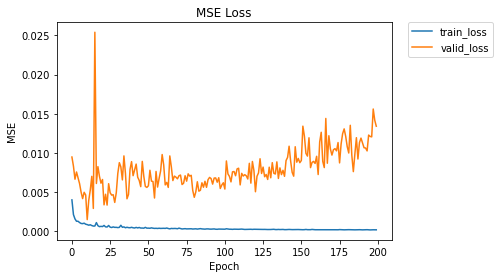

In [164]:
plt.plot(train_losses_model1,label='train_loss')
plt.plot(valid_losses1,label='valid_loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
    #plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('train_val_loss.png')


In [165]:
ytt1 = []
for i, (x, y) in enumerate(val_loader1):
    ytt1.append(y)


In [166]:
#sample = val_preds[:0]
sample_size = 203
sample1 = val_preds1[0]
sample_y1 = ytt1[0]
for i in range(sample_size):
    sample1 = torch.cat((sample1,val_preds1[i]),0)
    sample_y1 = torch.cat((sample_y1,ytt1[i]),0)


In [167]:
val_preds_sample1 = torch.tensor(sample1, device = 'cpu')

In [168]:
denorm_val_preds1 = val_preds_sample1 * (max_pm - min_pm) + min_pm
denorm_val_preds1[1]

tensor([141.5355])

In [169]:
denorm_y1 = sample_y1 * (max_pm - min_pm) + min_pm
denorm_y1[1]

tensor([40.])

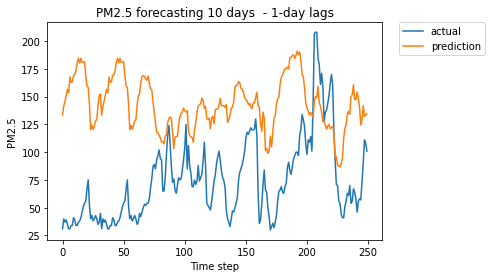

In [170]:
plt.plot(denorm_y1[:250],label='actual')
plt.plot(denorm_val_preds1[:250],label='prediction')
plt.title('PM2.5 forecasting 10 days  - 1-day lags')
plt.xlabel('Time step')
plt.ylabel('PM2.5')
    #plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('pm2_pred_actual.png')


In [173]:
import sklearn.metrics as metrics
mae1 = metrics.mean_absolute_error(denorm_y1, denorm_val_preds1)
mse1 = metrics.mean_squared_error(denorm_y1, denorm_val_preds1)
rmse1 = np.sqrt(mse1) # or mse**(0.5)  
r21 = metrics.r2_score(denorm_y1, denorm_val_preds1)

print("Results of sklearn.metrics:")
print("MAE:",mae1)
print("RMSE:", rmse1)
print("R-Squared:", 1-r21)

Results of sklearn.metrics:
MAE: 96.966034
RMSE: 115.6379
R-Squared: 1.8181432891084746


## 7-days Lag

In [174]:
num_epochs= 200
train_losses7, valid_losses7, val_preds7= experiment(model_Cnn_Lstm, optimizer, criterion, num_epochs, train_loader7, val_loader7)

Beginning training...
Epoch 1/200 : training loss = 0.0008956851913194312; Validation loss = 0.006919063721978265
Epoch 2/200 : training loss = 0.000637345182122633; Validation loss = 0.008263237828265374
Epoch 3/200 : training loss = 0.0005170402950663968; Validation loss = 0.008371255463174949
Epoch 4/200 : training loss = 0.00045022349866300474; Validation loss = 0.008160002352255946
Epoch 5/200 : training loss = 0.000441412567111284; Validation loss = 0.008864159919640362
Epoch 6/200 : training loss = 0.0004223419531010253; Validation loss = 0.008236761575423756
Epoch 7/200 : training loss = 0.0004406546361396309; Validation loss = 0.009271353673471849
Epoch 8/200 : training loss = 0.0004075057529660184; Validation loss = 0.008676851108165963
Epoch 9/200 : training loss = 0.0004076938682050302; Validation loss = 0.008235775975448468
Epoch 10/200 : training loss = 0.00038686713364639906; Validation loss = 0.009257493312859641
Epoch 11/200 : training loss = 0.0003958179072906411; Val

In [175]:
train_losses_model7 = [mean(train_loss7) for train_loss7 in train_losses7]

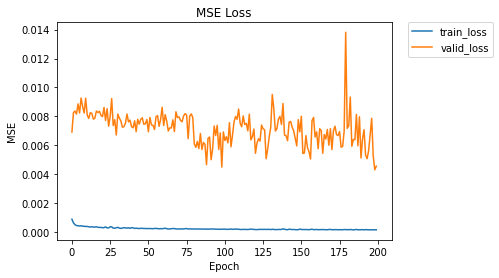

In [176]:
plt.plot(train_losses_model7,label='train_loss')
plt.plot(valid_losses7,label='valid_loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
    #plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('train_val_loss_7days.png')


In [177]:
ytt7 = []
for i, (x, y) in enumerate(val_loader7):
    ytt7.append(y)


In [178]:
len(ytt7)

199

In [179]:
#sample = val_preds[:0]
sample_size7 = 198
sample7 = val_preds7[0]
sample_y7 = ytt7[0]
for i in range(sample_size7):
    sample7 = torch.cat((sample7,val_preds7[i]),0)
    sample_y7 = torch.cat((sample_y7,ytt7[i]),0)


In [180]:
val_preds_sample7 = torch.tensor(sample7, device = 'cpu')

In [181]:
denorm_val_preds7 = val_preds_sample7 * (max_pm - min_pm) + min_pm
denorm_val_preds7[1]

tensor([40.4897])

In [182]:
denorm_y7 = sample_y7 * (max_pm - min_pm) + min_pm
denorm_y7[1]

tensor([65.])

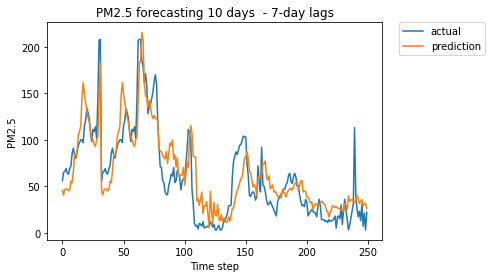

In [183]:
plt.plot(denorm_y7[:250],label='actual')
plt.plot(denorm_val_preds7[:250],label='prediction')
plt.title('PM2.5 forecasting 10 days  - 7-day lags')
plt.xlabel('Time step')
plt.ylabel('PM2.5')
    #plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('pm2_pred_actual_7days.png')


In [185]:
mae7 = metrics.mean_absolute_error(denorm_y7, denorm_val_preds7)
mse7 = metrics.mean_squared_error(denorm_y7, denorm_val_preds7)
rmse7 = np.sqrt(mse7) # or mse**(0.5)  
r27 = metrics.r2_score(denorm_y7, denorm_val_preds7)

print("Results of sklearn.metrics:")
print("MAE:",mae7)
print("RMSE:", rmse7)
print("R-Squared:", 1-r27)

Results of sklearn.metrics:
MAE: 37.14925
RMSE: 67.308914
R-Squared: 0.602952317113865
